In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter


## Splitting data into Train and Test

In [2]:
prepeocessed_data = pd.read_csv('preprocessed_data.csv', nrows=50000)
prepeocessed_data.head(2)

Unnamed: 0  Unnamed: 0.1       id                        teacher_id  \
0           0          8393  p205479  2bf07ba08945e5d8b2a3f269b2b3cfe5   
1           1         37728  p043609  3f60494c61921b3b43ab61bdde2904df   

  teacher_prefix school_state                 Date project_grade_category  \
0            MRS           CA  2016-04-27 00:27:36          Grades_PreK_2   
1             MS           UT  2016-04-27 00:31:25             Grades_3_5   

                                  project_title  \
0  Engineering STEAM into the Primary Classroom   
1                       Sensory Tools for Focus   

                                     project_essay_1  ...  \
0  I have been fortunate enough to use the Fairy ...  ...   
1  Imagine being 8-9 years old. You're in your th...  ...   

                                     project_essay_3  \
0  Each month I try to do several science or STEM...   
1  It is tough to do more than one thing at a tim...   

                                     project_essay_4  \
0  It is challenging to develop high quality scie...   
1  When my students are able to calm themselves d...   

                            project_resource_summary  \
0  My students need STEM kits to learn critical s...   
1  My students need Boogie Boards for quiet senso...   

  teacher_number_of_previously_posted_projects  project_is_approved  \
0                                           53                    1   
1                                            4                    1   

   clean_categories                 clean_subcategories  \
0      Math_Science  AppliedSciences Health_LifeScience   
1      SpecialNeeds                        SpecialNeeds   

                                               essay   price  quantity  
0  I have been fortunate enough to use the Fairy ...  725.05         4  
1  Imagine being 8-9 years old. You're in your th...  213.03         8  

[2 rows x 21 columns]

In [3]:
y = prepeocessed_data['project_is_approved'].values
X = prepeocessed_data.drop(['project_is_approved'], axis=1)
X = X.drop(['Unnamed: 0'], axis=1)
X = X.drop(['Unnamed: 0.1'], axis=1)
X.shape

(50000, 18)

In [4]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)
X_test.shape

(16500, 18)

In [5]:
X_train.head(2)

id                        teacher_id teacher_prefix school_state  \
7609   p252673  a1428f9e4c264117f5949b08e288774d             MS           IL   
43275  p091186  be4e343f5bb4477df7dcd9e769c0a185            MRS           OK   

                      Date project_grade_category  \
7609   2016-06-06 23:28:21             Grades_3_5   
43275  2016-09-03 13:06:31             Grades_3_5   

                                           project_title  \
7609                              Stand Up for Learning!   
43275  Help Support My Third Grade Superheroes With T...   

                                         project_essay_1  \
7609   My students live in a low-income/high poverty,...   
43275  My wonderful students are so excited about bei...   

                                         project_essay_2 project_essay_3  \
7609   My students are active and need to move to lea...             NaN   
43275  The addition of an Ipad mini tablet will help ...             NaN   

      project_essay_4                           project_resource_summary  \
7609              NaN  My students need 2 stand up desks with swingin...   
43275             NaN  My students need a new Apple iPad mini to assi...   

       teacher_number_of_previously_posted_projects  \
7609                                             45   
43275                                             0   

                      clean_categories                 clean_subcategories  \
7609   Health_Sports Literacy_Language  Health_Wellness Literature_Writing   
43275   Literacy_Language Math_Science                Literacy Mathematics   

                                                   essay   price  quantity  
7609   My students live in a low-income/high poverty,...  265.27         2  
43275  My wonderful students are so excited about bei...  289.99         2

In [6]:
y_train

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [7]:
X_test.head(2)

id                        teacher_id teacher_prefix school_state  \
36600  p130934  ed2438ef62186da80bd3bb9dc3dc8dd4            MRS           NY   
14058  p108157  cae2d55db3c302e65107a7703e043af1             MS           NC   

                      Date project_grade_category  \
36600  2016-08-26 00:26:37          Grades_PreK_2   
14058  2016-07-12 15:08:58             Grades_3_5   

                          project_title  \
36600   Help Give the Gift of Literacy!   
14058  All The Things We Are Able To Do   

                                         project_essay_1  \
36600  A typical day in my classroom could be describ...   
14058  My students are...special!\r\n\r\nEverything a...   

                                         project_essay_2 project_essay_3  \
36600  My students need one iPod Touch MP3 player and...             NaN   
14058  The donations to this project will make a diff...             NaN   

      project_essay_4                           project_resource_summary  \
36600             NaN  My students need one iPod Touch MP3 player and...   
14058             NaN  My students need these items for the upcoming ...   

       teacher_number_of_previously_posted_projects  \
36600                                             6   
14058                                             2   

                        clean_categories        clean_subcategories  \
36600  AppliedLearning Literacy_Language  EarlyDevelopment Literacy   
14058                  Literacy_Language         Literature_Writing   

                                                   essay   price  quantity  
36600  A typical day in my classroom could be describ...  249.94         6  
14058  My students are...special!\r\n\r\nEverything a...  176.92        27

In [8]:
y_test

array([1, 0, 1, ..., 0, 0, 1], dtype=int64)

## 1.4 Response Encoding Categorical and Numerical features

# Function to create dictionary with accept and reject rate for categories

In [9]:
def cat_dict(category_name):    
    """
    This function returns a dictionary, with accept and reject rate for a given categorical feature name.
    """
    cat_features = dict(X_train[category_name].value_counts()) 
    
    #the above line creates a dictionary with feature names as keys and their counts as values
    
    cat_feature_dict = {}
    cat_feature_dict = {k : [0,0,v] for k,v in cat_features.items()} 
    
    #we'll create another dictionary with feature names as keys and a list [0, 0, counts] as values

    for i, cat in enumerate(X_train[category_name]):
        if y_train[i] == 1:
            cat_feature_dict[cat][1] += 1
        else:
            cat_feature_dict[cat][0] += 1
            
    #this for loop is to check what's the corresponding y value for a feature name.
    #if it's 1, we'll increment value at index 1, if it's 0 we'll increment value at index 0
    #so, the resultant dict will contain feature name as keys and a list like this [# rejected, # accepted, total count]
    
    cat_feature_dict = {k : [(v[0]/v[2]), (v[1]/v[2])] for k, v in cat_feature_dict.items()}
    
    #this dictionary comprehension converts our values list from [# rejected, # accepted, total count] to
    #[rejected %, accepted %] by dividing #rejected points by total number of points and 
    #accepted points by total number of points
    
    return cat_feature_dict

# Function to add the obtained response encoding values to the dataset

In [10]:
def add_response(name,dictionary,dataset):
    """
    This function is to add the response encoding values to the data set,
    using the given dictionary containing accept and reject rates.
    """
    rejected = []
    accepted = []
    for i in dataset[name]:
        try:
            rejected.append(dictionary[i][0])
            accepted.append(dictionary[i][1])
            
            #in this try block we'll check if the feature name is present in our datasest or not,
            #if it's present we'll append it's corresponding accept rate and reject rate to the respective lists
            #if the feature name is not present, we'll handle this exception in the except block
            #by appending '0.5' to accepted and rejected list
            
        except:
            rejected.append(0.5)
            accepted.append(0.5)
    dataset[name+'_rej'] = rejected
    dataset[name+'_acc'] = accepted
    
    #Once the entire data set is checked, We'll add the obtained accepted and rejected lists,
    #to the dataset as columns in the format 'feature_name_acc' and 'feature_name_rej'

### 1.4.1 Response encoding categorical features: teacher_prefix

In [11]:
teacher_prefix_dict = cat_dict('teacher_prefix')
print('Response encoding values for category "teacher_prefix" are \n\n{}'.format(teacher_prefix_dict))

Response encoding values for category "teacher_prefix" are 

{'MRS': [0.15337321369225657, 0.8466267863077435], 'MS': [0.16581632653061223, 0.8341836734693877], 'MR': [0.1653000983929157, 0.8346999016070843], 'TEACHER': [0.22397476340694006, 0.7760252365930599], 'DR': [0.0, 1.0]}


In [12]:
#adding response encoding to our dataset
add_response('teacher_prefix',teacher_prefix_dict,X_train)
add_response('teacher_prefix',teacher_prefix_dict,X_test)

In [13]:
X_train[['teacher_prefix','teacher_prefix_acc','teacher_prefix_rej']].head(5)

teacher_prefix  teacher_prefix_acc  teacher_prefix_rej
7609              MS            0.834184            0.165816
43275            MRS            0.846627            0.153373
9246             MRS            0.846627            0.153373
31229            MRS            0.846627            0.153373
9492             MRS            0.846627            0.153373

In [14]:
X_test[['teacher_prefix','teacher_prefix_acc','teacher_prefix_rej']].head(5)

teacher_prefix  teacher_prefix_acc  teacher_prefix_rej
36600            MRS            0.846627            0.153373
14058             MS            0.834184            0.165816
32477            MRS            0.846627            0.153373
12054            MRS            0.846627            0.153373
4845              MR            0.834700            0.165300

### 1.4.2 Response encoding categorical features: clean_categories

In [15]:
clean_categories_dict = cat_dict('clean_categories')
print('Response encoding values for category "clean_categories" are \n\n{}'.format(clean_categories_dict))

Response encoding values for category "clean_categories" are 

{'Literacy_Language': [0.14535367545076283, 0.8546463245492372], 'Math_Science': [0.1977889447236181, 0.8022110552763819], 'Health_Sports': [0.14263668430335097, 0.857363315696649], 'Literacy_Language Math_Science': [0.14121170237272518, 0.8587882976272748], 'Music_Arts': [0.14553314121037464, 0.8544668587896254], 'SpecialNeeds': [0.19383259911894274, 0.8061674008810573], 'Literacy_Language SpecialNeeds': [0.15398230088495576, 0.8460176991150442], 'AppliedLearning': [0.1931097008159565, 0.8068902991840435], 'Math_Science Literacy_Language': [0.16137931034482758, 0.8386206896551724], 'AppliedLearning Literacy_Language': [0.1324599708879185, 0.8675400291120815], 'Literacy_Language Music_Arts': [0.17162872154115585, 0.8283712784588442], 'History_Civics': [0.16666666666666666, 0.8333333333333334], 'Math_Science SpecialNeeds': [0.16030534351145037, 0.8396946564885496], 'Health_Sports SpecialNeeds': [0.12601626016260162, 0.873983

In [16]:
#adding response encoding to our dataset
add_response('clean_categories',clean_categories_dict,X_train)
add_response('clean_categories',clean_categories_dict,X_test)

In [17]:
X_train[['clean_categories','clean_categories_acc','clean_categories_rej']].head(5)

clean_categories  clean_categories_acc  \
7609   Health_Sports Literacy_Language              0.858407   
43275   Literacy_Language Math_Science              0.858788   
9246                 Literacy_Language              0.854646   
31229   Literacy_Language Math_Science              0.858788   
9492                 Literacy_Language              0.854646   

       clean_categories_rej  
7609               0.141593  
43275              0.141212  
9246               0.145354  
31229              0.141212  
9492               0.145354

In [18]:
X_test[['clean_categories','clean_categories_acc','clean_categories_rej']].head(5)

clean_categories  clean_categories_acc  \
36600  AppliedLearning Literacy_Language              0.867540   
14058                  Literacy_Language              0.854646   
32477                       Math_Science              0.802211   
12054     Literacy_Language Math_Science              0.858788   
4845                   Literacy_Language              0.854646   

       clean_categories_rej  
36600              0.132460  
14058              0.145354  
32477              0.197789  
12054              0.141212  
4845               0.145354

### 1.4.3 Response encoding categorical features: clean_subcategories

In [19]:
clean_subcategories_dict = cat_dict('clean_subcategories')
print('Response encoding values for category "clean_subcategories" are \n\n{}'.format(clean_subcategories_dict))

Response encoding values for category "clean_subcategories" are 

{'Literacy': [0.13218390804597702, 0.867816091954023], 'Literacy Mathematics': [0.14097821619399917, 0.8590217838060008], 'Literacy Literature_Writing': [0.14912280701754385, 0.8508771929824561], 'Literature_Writing Mathematics': [0.1395477109762824, 0.8604522890237176], 'Health_Wellness': [0.11704545454545455, 0.8829545454545454], 'Mathematics': [0.20757097791798107, 0.7924290220820189], 'Literature_Writing': [0.14427157001414428, 0.8557284299858557], 'SpecialNeeds': [0.19383259911894274, 0.8061674008810573], 'Gym_Fitness Health_Wellness': [0.12375790424570912, 0.8762420957542909], 'AppliedSciences Mathematics': [0.1891891891891892, 0.8108108108108109], 'AppliedSciences': [0.20057720057720058, 0.7994227994227994], 'Literacy SpecialNeeds': [0.13623188405797101, 0.863768115942029], 'ESL Literacy': [0.15880503144654087, 0.8411949685534591], 'VisualArts': [0.1595744680851064, 0.8404255319148937], 'Gym_Fitness': [0.16, 0.84]

In [20]:
#adding response encoding to our dataset
add_response('clean_subcategories',clean_subcategories_dict,X_train)
add_response('clean_subcategories',clean_subcategories_dict,X_test)

In [21]:
X_train[['clean_subcategories','clean_subcategories_acc','clean_subcategories_rej']].head(5)

clean_subcategories  clean_subcategories_acc  \
7609   Health_Wellness Literature_Writing                 0.869919   
43275                Literacy Mathematics                 0.859022   
9246                             Literacy                 0.867816   
31229      Literature_Writing Mathematics                 0.860452   
9492                   Literature_Writing                 0.855728   

       clean_subcategories_rej  
7609                  0.130081  
43275                 0.140978  
9246                  0.132184  
31229                 0.139548  
9492                  0.144272

In [22]:
X_test[['clean_subcategories','clean_subcategories_acc','clean_subcategories_rej']].head(5)

clean_subcategories  clean_subcategories_acc  \
36600  EarlyDevelopment Literacy                 0.846491   
14058         Literature_Writing                 0.855728   
32477            AppliedSciences                 0.799423   
12054       Literacy Mathematics                 0.859022   
4845                    Literacy                 0.867816   

       clean_subcategories_rej  
36600                 0.153509  
14058                 0.144272  
32477                 0.200577  
12054                 0.140978  
4845                  0.132184

### 1.4.4 Response encoding categorical features: school_state

In [23]:
school_state_dict = cat_dict('school_state')
print('Response encoding values for category "school_state" are \n\n{}'.format(school_state_dict))

Response encoding values for category "school_state" are 

{'CA': [0.1532404603270745, 0.8467595396729255], 'TX': [0.20157610949813357, 0.7984238905018665], 'FL': [0.16998542982030113, 0.8300145701796989], 'NY': [0.14862104187946884, 0.8513789581205311], 'NC': [0.16563275434243177, 0.8343672456575683], 'GA': [0.1728395061728395, 0.8271604938271605], 'IL': [0.1391304347826087, 0.8608695652173913], 'SC': [0.15288888888888888, 0.8471111111111111], 'PA': [0.15021459227467812, 0.8497854077253219], 'MI': [0.1581858407079646, 0.8418141592920354], 'IN': [0.14512195121951219, 0.8548780487804878], 'MO': [0.14058679706601468, 0.8594132029339854], 'LA': [0.19220779220779222, 0.8077922077922078], 'OK': [0.16976127320954906, 0.830238726790451], 'OH': [0.13941018766756033, 0.8605898123324397], 'MA': [0.15220483641536273, 0.8477951635846372], 'WA': [0.11175616835994194, 0.888243831640058], 'AZ': [0.1659056316590563, 0.8340943683409436], 'VA': [0.15288611544461778, 0.8471138845553822], 'UT': [0.1661442

In [24]:
#adding response encoding to our dataset
add_response('school_state',school_state_dict,X_train)
add_response('school_state',school_state_dict,X_test)

In [25]:
X_train[['school_state','school_state_acc','school_state_rej']].head(5)

school_state  school_state_acc  school_state_rej
7609            IL          0.860870          0.139130
43275           OK          0.830239          0.169761
9246            LA          0.807792          0.192208
31229           CT          0.849890          0.150110
9492            SC          0.847111          0.152889

In [26]:
X_test[['school_state','school_state_acc','school_state_rej']].head(5)

school_state  school_state_acc  school_state_rej
36600           NY          0.851379          0.148621
14058           NC          0.834367          0.165633
32477           TX          0.798424          0.201576
12054           NC          0.834367          0.165633
4845            FL          0.830015          0.169985

### 1.4.5 Response encoding categorical features: project_grade_category

In [27]:
project_grade_category_dict = cat_dict('project_grade_category')
print('Response encoding values for category "project_grade_category" are \n\n{}'.format(project_grade_category_dict))

Response encoding values for category "project_grade_category" are 

{'Grades_PreK_2': [0.16182632567548041, 0.8381736743245196], 'Grades_3_5': [0.15229582895198038, 0.8477041710480197], 'Grades_6_8': [0.16715314263475384, 0.8328468573652461], 'Grades_9_12': [0.16993884776311555, 0.8300611522368845]}


In [28]:
#adding response encoding to our dataset
add_response('project_grade_category',project_grade_category_dict,X_train)
add_response('project_grade_category',project_grade_category_dict,X_test)

In [29]:
X_train[['project_grade_category','project_grade_category_acc','project_grade_category_rej']].head(5)

project_grade_category  project_grade_category_acc  \
7609              Grades_3_5                    0.847704   
43275             Grades_3_5                    0.847704   
9246           Grades_PreK_2                    0.838174   
31229             Grades_6_8                    0.832847   
9492              Grades_6_8                    0.832847   

       project_grade_category_rej  
7609                     0.152296  
43275                    0.152296  
9246                     0.161826  
31229                    0.167153  
9492                     0.167153

In [30]:
X_test[['project_grade_category','project_grade_category_acc','project_grade_category_rej']].head(5)

project_grade_category  project_grade_category_acc  \
36600          Grades_PreK_2                    0.838174   
14058             Grades_3_5                    0.847704   
32477             Grades_3_5                    0.847704   
12054             Grades_3_5                    0.847704   
4845              Grades_3_5                    0.847704   

       project_grade_category_rej  
36600                    0.161826  
14058                    0.152296  
32477                    0.152296  
12054                    0.152296  
4845                     0.152296

In [31]:
X_train.head(2)

id                        teacher_id teacher_prefix school_state  \
7609   p252673  a1428f9e4c264117f5949b08e288774d             MS           IL   
43275  p091186  be4e343f5bb4477df7dcd9e769c0a185            MRS           OK   

                      Date project_grade_category  \
7609   2016-06-06 23:28:21             Grades_3_5   
43275  2016-09-03 13:06:31             Grades_3_5   

                                           project_title  \
7609                              Stand Up for Learning!   
43275  Help Support My Third Grade Superheroes With T...   

                                         project_essay_1  \
7609   My students live in a low-income/high poverty,...   
43275  My wonderful students are so excited about bei...   

                                         project_essay_2 project_essay_3  ...  \
7609   My students are active and need to move to lea...             NaN  ...   
43275  The addition of an Ipad mini tablet will help ...             NaN  ...   

      teacher_prefix_rej teacher_prefix_acc  clean_categories_rej  \
7609            0.165816           0.834184              0.141593   
43275           0.153373           0.846627              0.141212   

      clean_categories_acc clean_subcategories_rej clean_subcategories_acc  \
7609              0.858407                0.130081                0.869919   
43275             0.858788                0.140978                0.859022   

       school_state_rej  school_state_acc  project_grade_category_rej  \
7609           0.139130          0.860870                    0.152296   
43275          0.169761          0.830239                    0.152296   

       project_grade_category_acc  
7609                     0.847704  
43275                    0.847704  

[2 rows x 28 columns]

In [32]:
X_test.head(2)

id                        teacher_id teacher_prefix school_state  \
36600  p130934  ed2438ef62186da80bd3bb9dc3dc8dd4            MRS           NY   
14058  p108157  cae2d55db3c302e65107a7703e043af1             MS           NC   

                      Date project_grade_category  \
36600  2016-08-26 00:26:37          Grades_PreK_2   
14058  2016-07-12 15:08:58             Grades_3_5   

                          project_title  \
36600   Help Give the Gift of Literacy!   
14058  All The Things We Are Able To Do   

                                         project_essay_1  \
36600  A typical day in my classroom could be describ...   
14058  My students are...special!\r\n\r\nEverything a...   

                                         project_essay_2 project_essay_3  ...  \
36600  My students need one iPod Touch MP3 player and...             NaN  ...   
14058  The donations to this project will make a diff...             NaN  ...   

      teacher_prefix_rej teacher_prefix_acc  clean_categories_rej  \
36600           0.153373           0.846627              0.132460   
14058           0.165816           0.834184              0.145354   

      clean_categories_acc clean_subcategories_rej clean_subcategories_acc  \
36600             0.867540                0.153509                0.846491   
14058             0.854646                0.144272                0.855728   

       school_state_rej  school_state_acc  project_grade_category_rej  \
36600          0.148621          0.851379                    0.161826   
14058          0.165633          0.834367                    0.152296   

       project_grade_category_acc  
36600                    0.838174  
14058                    0.847704  

[2 rows x 28 columns]

### 1.4.6 encoding numerical features: price

In [33]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1)).reshape(-1,1)
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print(X_train_price_norm)
print(X_test_price_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00302532]
 [0.00330724]
 [0.00396301]
 ...
 [0.00073515]
 [0.00287649]
 [0.00090781]]
[[0.00386803]
 [0.00273798]
 [0.00010818]
 ...
 [0.00672966]
 [0.00616155]
 [0.00538187]]


### 1.4.7 encoding numerical features: teacher_number_of_previously_posted_projects

In [34]:

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_ppp_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)
X_test_ppp_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_ppp_norm.shape, y_train.shape)
print(X_test_ppp_norm.shape, y_test.shape)
print(X_train_ppp_norm)
print(X_test_ppp_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00953614]
 [0.        ]
 [0.        ]
 ...
 [0.00127149]
 [0.        ]
 [0.00021191]]
[[0.00182826]
 [0.00060942]
 [0.00060942]
 ...
 [0.        ]
 [0.00030471]
 [0.        ]]


### 1.4.8 encoding numerical features: quantity

In [35]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['quantity'].values.reshape(1,-1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(1,-1)).reshape(-1,1)
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_quantity_norm.shape, y_train.shape)
print(X_test_quantity_norm.shape, y_test.shape)
print(X_train_quantity_norm)
print(X_test_quantity_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00033515]
 [0.00033515]
 [0.00067031]
 ...
 [0.00100546]
 [0.00469214]
 [0.00050273]]
[[0.00134931]
 [0.00607192]
 [0.02248858]
 ...
 [0.00719635]
 [0.00494749]
 [0.00359817]]


### 1.4.9 encoding numerical features: sentiment score's of each of the essay

In [36]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
ss_train = []
ss_test = []
for essay in X_train['essay']:
    ss_train.append(sid.polarity_scores(essay)['pos'])
    
for essay in X_test['essay']:
    ss_test.append(sid.polarity_scores(essay)['pos'])

# we can use these 4 things as features/attributes (neg, neu, pos, compound)
# neg: 0.0, neu: 0.753, pos: 0.247, compound: 0.93

print(len(ss_train))
print(len(ss_test))
print(ss_train[7])
print(ss_test[7])

ss_train_array = np.array(ss_train)
ss_test_array = np.array(ss_test)
print(ss_train_array.shape)
print(ss_test_array.shape)

33500
16500
0.128
0.131
(33500,)
(16500,)


In [37]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(ss_train_array.reshape(1,-1))

X_train_ss_norm = normalizer.transform(ss_train_array.reshape(1,-1)).reshape(-1,1)
X_test_ss_norm = normalizer.transform(ss_test_array.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_ss_norm.shape, y_train.shape)
print(X_test_ss_norm.shape, y_test.shape)
print(X_train_ss_norm)
print(X_test_ss_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00323285]
 [0.00652557]
 [0.00475948]
 ...
 [0.00613643]
 [0.00736372]
 [0.00457987]]
[[0.00632946]
 [0.00774075]
 [0.00799735]
 ...
 [0.00620116]
 [0.00692819]
 [0.00637222]]


### 1.4.10 encoding numerical features: number of words in the title

In [38]:
title_word_count_train = []
title_word_count_test = []


for i in X_train['project_title']:
    title_word_count_train.append(len(i.split()))

for i in X_test['project_title']:
    title_word_count_test.append(len(i.split()))

print(len(title_word_count_train))
print(len(title_word_count_test))
print(title_word_count_train[7])
print(title_word_count_train[7])

title_word_count_train_array = np.array(title_word_count_train)
title_word_count_test_array = np.array(title_word_count_test)
print(title_word_count_train_array.shape)
print(title_word_count_test_array.shape)

33500
16500
4
4
(33500,)
(16500,)


In [39]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(title_word_count_train_array.reshape(1,-1))

X_train_twc_norm = normalizer.transform(title_word_count_train_array.reshape(1,-1)).reshape(-1,1)
X_test_twc_norm = normalizer.transform(title_word_count_test_array.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_twc_norm.shape, y_train.shape)
print(X_test_twc_norm.shape, y_test.shape)
print(X_train_twc_norm)
print(X_test_twc_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00390217]
 [0.00975542]
 [0.00780433]
 ...
 [0.00975542]
 [0.00487771]
 [0.00877987]]
[[0.00827674]
 [0.01103565]
 [0.00965619]
 ...
 [0.0124151 ]
 [0.01103565]
 [0.0124151 ]]


### 1.4.11 encoding numerical features: number of words in the combine essays

In [40]:
essay_word_count_train = []
essay_word_count_test = []
for i in X_train['essay']:
    essay_word_count_train.append(len(i.split()))


for i in X_test['essay']:
    essay_word_count_test.append(len(i.split()))

print(len(essay_word_count_train))
print(len(essay_word_count_test))
print(essay_word_count_train[7])
print(essay_word_count_test[7])


essay_word_count_train_array = np.array(essay_word_count_train)
essay_word_count_test_array = np.array(essay_word_count_test)
print(essay_word_count_train_array.shape)
print(essay_word_count_test_array.shape)

33500
16500
341
321
(33500,)
(16500,)


In [41]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
normalizer.fit(essay_word_count_train_array.reshape(1,-1))

X_train_ewc_norm = normalizer.transform(essay_word_count_train_array.reshape(1,-1)).reshape(-1,1)
X_test_ewc_norm = normalizer.transform(essay_word_count_test_array.reshape(1,-1)).reshape(-1,1)

print("After vectorizations")
print(X_train_ewc_norm.shape, y_train.shape)
print(X_test_ewc_norm.shape, y_test.shape)
print(X_train_ewc_norm)
print(X_test_ewc_norm)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)
[[0.00417325]
 [0.00364137]
 [0.00609622]
 ...
 [0.00384594]
 [0.0038664 ]
 [0.00550297]]
[[0.0109722 ]
 [0.00536937]
 [0.00583628]
 ...
 [0.00612809]
 [0.00723698]
 [0.00787897]]


## 1.5 Vectorizing Text features

### 1.5.1 Vectorizing using BOW 

#### Essay

In [42]:

print(X_train.shape, y_train.shape)
#print(X_cv.shape, y_cv.shape)
print(X_test.shape, y_test.shape)

print("\n\n")


vectorizer_bow_essay = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow_essay.fit(X_train['essay'].values) # fit has to happen only on train data

X_train_essay_bow = vectorizer_bow_essay.transform(X_train['essay'].values)
X_test_essay_bow = vectorizer_bow_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, y_train.shape)
print(X_test_essay_bow.shape, y_test.shape)


(33500, 28) (33500,)
(16500, 28) (16500,)



After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


#### project_title

In [43]:
vectorizer_bow_title = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow_title.fit(X_train['project_title'].values) # fit has to happen only on train data


X_train_titles_bow = vectorizer_bow_title.transform(X_train['project_title'].values)
X_test_titles_bow = vectorizer_bow_title.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_titles_bow.shape, y_train.shape)
print(X_test_titles_bow.shape, y_test.shape)

After vectorizations
(33500, 4024) (33500,)
(16500, 4024) (16500,)


#### project_resource_summary

In [44]:
vectorizer_bow_rs = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_bow_rs.fit(X_train['project_resource_summary'].values) # fit has to happen only on train data


X_train_psr_bow = vectorizer_bow_rs.transform(X_train['project_resource_summary'].values)
X_test_psr_bow = vectorizer_bow_rs.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_psr_bow.shape, y_train.shape)
print(X_test_psr_bow.shape, y_test.shape)

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


### 1.5.2 Vectorizing using TFIDF

#### essay

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_essay = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_essay.fit(X_train['essay'].values)

X_train_essay_tfidf = vectorizer_tfidf_essay.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_tfidf_essay.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


#### project_title

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_title = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_title.fit(X_train['project_title'].values)

X_train_titles_tfidf = vectorizer_tfidf_title.transform(X_train['project_title'].values)
X_test_titles_tfidf = vectorizer_tfidf_title.transform(X_test['project_title'].values)

print("After vectorizations")
print(X_train_titles_tfidf.shape, y_train.shape)
print(X_test_titles_tfidf.shape, y_test.shape)

After vectorizations
(33500, 4024) (33500,)
(16500, 4024) (16500,)


#### project_resource_summary

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer_tfidf_rs = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_tfidf_rs.fit(X_train['project_resource_summary'].values)

X_train_prs_tfidf = vectorizer_tfidf_rs.transform(X_train['project_resource_summary'].values)
X_test_prs_tfidf = vectorizer_tfidf_rs.transform(X_test['project_resource_summary'].values)

print("After vectorizations")
print(X_train_prs_tfidf.shape, y_train.shape)
print(X_test_prs_tfidf.shape, y_test.shape)

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


### 1.5.3 Vectorizing using AVG W2V

In [48]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

#### essay

In [49]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_essay_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_train.append(vector)

print(len(avg_w2v_essay_train))
print(len(avg_w2v_essay_train[0]))

100%|██████████████████████████████████████████████████████████████████████████| 33500/33500 [00:11<00:00, 2913.18it/s]

33500
300


In [50]:
avg_w2v_essay_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_essay_test.append(vector)

100%|██████████████████████████████████████████████████████████████████████████| 16500/16500 [00:05<00:00, 2914.59it/s]


#### project_title

In [51]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_titles_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_titles_train.append(vector)

print(len(avg_w2v_titles_train))
print(len(avg_w2v_titles_train[0]))


100%|████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 148331.76it/s]

33500
300


In [52]:
avg_w2v_titles_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_titles_test.append(vector)

100%|████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 139181.15it/s]


#### project_resource_summary

In [53]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_prs_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_prs_train.append(vector)

print(len(avg_w2v_prs_train))
print(len(avg_w2v_prs_train[0]))


100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:01<00:00, 31223.83it/s]

33500
300


In [54]:
avg_w2v_prs_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_resource_summary'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_prs_test.append(vector)

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 31163.13it/s]


### 1.5.4 Vectorizing using TFIDF W2V

#### project_title

In [55]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_title'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_title_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_train.append(vector)

print(len(tfidf_w2v_title_train))
print(len(tfidf_w2v_title_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:00<00:00, 98856.98it/s]

33500
300


In [56]:
tfidf_w2v_title_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_title']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_title_test.append(vector)

print(len(tfidf_w2v_title_test))
print(len(tfidf_w2v_title_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:00<00:00, 96636.07it/s]

16500
300


#### essay

In [57]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_essay_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_train.append(vector)

print(len(tfidf_w2v_essay_train))
print(len(tfidf_w2v_essay_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 33500/33500 [02:13<00:00, 251.32it/s]

33500
300


In [58]:
tfidf_w2v_essay_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_essay_test.append(vector)

print(len(tfidf_w2v_essay_test))
print(len(tfidf_w2v_essay_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 16500/16500 [01:05<00:00, 251.92it/s]

16500
300


#### project_resource_summary

In [59]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['project_resource_summary'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_prs_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_prs_train.append(vector)

print(len(tfidf_w2v_prs_train))
print(len(tfidf_w2v_prs_train[0]))

100%|█████████████████████████████████████████████████████████████████████████| 33500/33500 [00:03<00:00, 10623.11it/s]

33500
300


In [60]:
tfidf_w2v_prs_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['project_resource_summary']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_prs_test.append(vector)

print(len(tfidf_w2v_prs_test))
print(len(tfidf_w2v_prs_test[0]))

100%|█████████████████████████████████████████████████████████████████████████| 16500/16500 [00:01<00:00, 10616.80it/s]

16500
300


### Merging all the categorical and numerical features with variations of text features

In [61]:
#Get all the response encoded feature colums from train data set

X_train_RC_cat_acc = X_train['clean_categories_acc'].values.reshape(-1,1)
X_train_RC_subcat_acc = X_train['clean_subcategories_acc'].values.reshape(-1,1)
X_train_RC_tp_acc = X_train['teacher_prefix_acc'].values.reshape(-1,1)
X_train_RC_state_acc = X_train['school_state_acc'].values.reshape(-1,1)
X_train_RC_pgc_acc = X_train['project_grade_category_acc'].values.reshape(-1,1)

X_train_RC_cat_rej = X_train['clean_categories_rej'].values.reshape(-1,1)
X_train_RC_subcat_rej = X_train['clean_subcategories_rej'].values.reshape(-1,1)
X_train_RC_tp_rej = X_train['teacher_prefix_rej'].values.reshape(-1,1)
X_train_RC_state_rej = X_train['school_state_rej'].values.reshape(-1,1)
X_train_RC_pgc_rej = X_train['project_grade_category_rej'].values.reshape(-1,1)

In [62]:
#Get all the response encoded feature colums from test data set

X_test_RC_cat_acc = X_test['clean_categories_acc'].values.reshape(-1,1)
X_test_RC_subcat_acc = X_test['clean_subcategories_acc'].values.reshape(-1,1)
X_test_RC_tp_acc = X_test['teacher_prefix_acc'].values.reshape(-1,1)
X_test_RC_state_acc = X_test['school_state_acc'].values.reshape(-1,1)
X_test_RC_pgc_acc = X_test['project_grade_category_acc'].values.reshape(-1,1)

X_test_RC_cat_rej = X_test['clean_categories_rej'].values.reshape(-1,1)
X_test_RC_subcat_rej = X_test['clean_subcategories_rej'].values.reshape(-1,1)
X_test_RC_tp_rej = X_test['teacher_prefix_rej'].values.reshape(-1,1)
X_test_RC_state_rej = X_test['school_state_rej'].values.reshape(-1,1)
X_test_RC_pgc_rej = X_test['project_grade_category_rej'].values.reshape(-1,1)

In [63]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_bow_matrix = hstack((X_train_RC_cat_acc, X_train_RC_subcat_acc, X_train_RC_tp_acc, X_train_RC_state_acc,
                             X_train_RC_pgc_acc, X_train_RC_cat_rej, X_train_RC_subcat_rej, X_train_RC_tp_rej,
                             X_train_RC_state_rej, X_train_RC_pgc_rej,
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm,
                             X_train_essay_bow, X_train_titles_bow, X_train_psr_bow)).tocsr()


X_test_bow_matrix = hstack((X_test_RC_cat_acc, X_test_RC_subcat_acc, X_test_RC_tp_acc, X_test_RC_state_acc,
                            X_test_RC_pgc_acc, X_test_RC_cat_rej, X_test_RC_subcat_rej, X_test_RC_tp_rej,
                            X_test_RC_state_rej, X_test_RC_pgc_rej, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            X_test_essay_bow, X_test_titles_bow, X_test_psr_bow)).tocsr()

print("Final Data matrix")
print(X_train_bow_matrix.shape, y_train.shape)
print(X_test_bow_matrix.shape, y_test.shape)

Final Data matrix
(33500, 14038) (33500,)
(16500, 14038) (16500,)


In [64]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack

X_train_tfidf_matrix = hstack((X_train_RC_cat_acc, X_train_RC_subcat_acc, X_train_RC_tp_acc, X_train_RC_state_acc,
                             X_train_RC_pgc_acc, X_train_RC_cat_rej, X_train_RC_subcat_rej, X_train_RC_tp_rej,
                             X_train_RC_state_rej, X_train_RC_pgc_rej, 
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm,
                             X_train_titles_tfidf, X_train_essay_tfidf, X_train_prs_tfidf)).tocsr()

X_test_tfidf_matrix = hstack((X_test_RC_cat_acc, X_test_RC_subcat_acc, X_test_RC_tp_acc, X_test_RC_state_acc,
                            X_test_RC_pgc_acc, X_test_RC_cat_rej, X_test_RC_subcat_rej, X_test_RC_tp_rej,
                            X_test_RC_state_rej, X_test_RC_pgc_rej, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            X_test_titles_tfidf, X_test_essay_tfidf, X_test_prs_tfidf)).tocsr()

print("Final Data matrix")
print(X_train_tfidf_matrix.shape, y_train.shape)
print(X_test_tfidf_matrix.shape, y_test.shape)


Final Data matrix
(33500, 14038) (33500,)
(16500, 14038) (16500,)


In [65]:
X_train_aw2v_matrix = np.hstack((X_train_RC_cat_acc, X_train_RC_subcat_acc, X_train_RC_tp_acc, X_train_RC_state_acc,
                             X_train_RC_pgc_acc, X_train_RC_cat_rej, X_train_RC_subcat_rej, X_train_RC_tp_rej,
                             X_train_RC_state_rej, X_train_RC_pgc_rej,
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm,
                             avg_w2v_essay_train, avg_w2v_titles_train, avg_w2v_prs_train))

X_test_aw2v_matrix = np.hstack((X_test_RC_cat_acc, X_test_RC_subcat_acc, X_test_RC_tp_acc, X_test_RC_state_acc,
                            X_test_RC_pgc_acc, X_test_RC_cat_rej, X_test_RC_subcat_rej, X_test_RC_tp_rej,
                            X_test_RC_state_rej, X_test_RC_pgc_rej, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            avg_w2v_essay_test, avg_w2v_titles_test, avg_w2v_prs_test))

print("Final Data matrix")
print(X_train_aw2v_matrix.shape, y_train.shape)
print(X_test_aw2v_matrix.shape, y_test.shape)

Final Data matrix
(33500, 914) (33500,)
(16500, 914) (16500,)


In [66]:
X_train_tw2v_matrix = np.hstack((X_train_RC_cat_acc, X_train_RC_subcat_acc, X_train_RC_tp_acc, X_train_RC_state_acc,
                             X_train_RC_pgc_acc, X_train_RC_cat_rej, X_train_RC_subcat_rej, X_train_RC_tp_rej,
                             X_train_RC_state_rej, X_train_RC_pgc_rej,
                             X_train_ewc_norm, X_train_twc_norm, X_train_ss_norm, X_train_quantity_norm, 
                             tfidf_w2v_essay_train, tfidf_w2v_title_train, tfidf_w2v_prs_train))

X_test_tw2v_matrix = np.hstack((X_test_RC_cat_acc, X_test_RC_subcat_acc, X_test_RC_tp_acc, X_test_RC_state_acc,
                            X_test_RC_pgc_acc, X_test_RC_cat_rej, X_test_RC_subcat_rej, X_test_RC_tp_rej,
                            X_test_RC_state_rej, X_test_RC_pgc_rej, 
                            X_test_ewc_norm, X_test_twc_norm, X_test_ss_norm, X_test_quantity_norm,
                            tfidf_w2v_essay_test, tfidf_w2v_title_test, tfidf_w2v_prs_test))

print("Final Data matrix")
print(X_train_tw2v_matrix.shape, y_train.shape)
print(X_test_tw2v_matrix.shape, y_test.shape)

Final Data matrix
(33500, 914) (33500,)
(16500, 914) (16500,)


## Finding Best Hyper parameter using K-Fold CV on BOW representation of text features

In [67]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'n_estimators' : [10, 50, 100, 250, 500, 1000, 2000]}
rf = RandomForestClassifier(class_weight =  "balanced")
clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_bow_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']


In [68]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

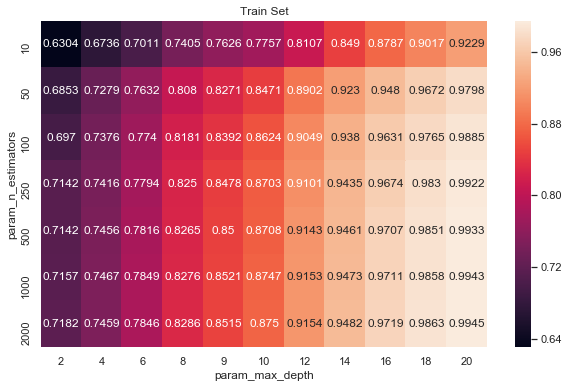

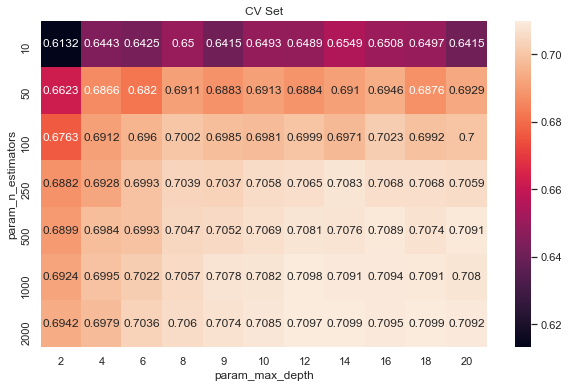

In [69]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [70]:
best_max_depth_bow = clf.best_params_['max_depth']
best_n_estimators_bow = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_bow,best_n_estimators_bow))

best value for max depth is 18 and best value for min samples split is 2000


## Finding Best Hyper parameter using K-Fold CV on TFIDF representation of text features

In [71]:
parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'n_estimators' : [10, 50, 100, 250, 500, 1000, 2000]}
rf = RandomForestClassifier(class_weight =  "balanced")
clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_tfidf_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [72]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

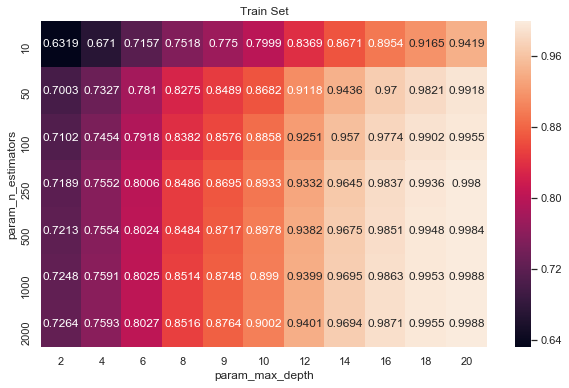

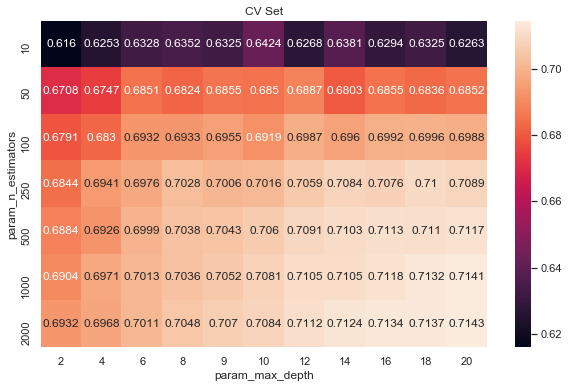

In [73]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [74]:
best_max_depth_tfidf = clf.best_params_['max_depth']
best_n_estimators_tfidf = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_tfidf,best_n_estimators_tfidf))

best value for max depth is 20 and best value for n_estimators is 2000


## Finding Best Hyper parameter using K-Fold CV on AVG W2V representation of text features

In [75]:
parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'n_estimators' : [10, 50, 100, 250, 500, 1000, 2000]}
rf = RandomForestClassifier(class_weight =  "balanced")
clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_aw2v_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [76]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

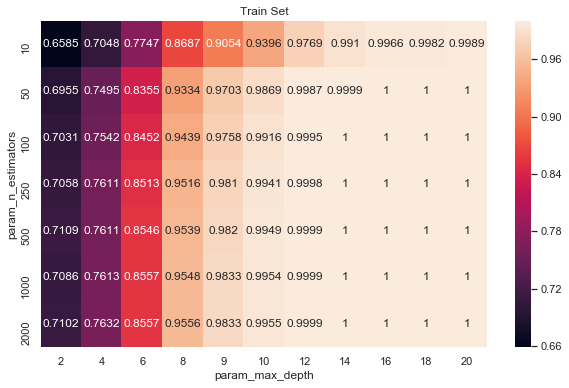

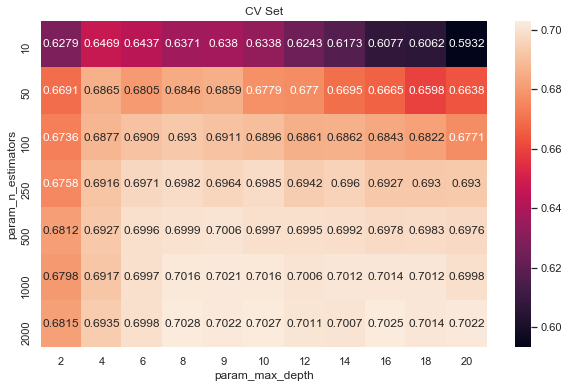

In [77]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [78]:
best_max_depth_aw2v = clf.best_params_['max_depth']
best_n_estimators_aw2v = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_aw2v,best_n_estimators_aw2v))

best value for max depth is 8 and best value for n_estimators is 2000


## Finding Best Hyper parameter using K-Fold CV on TFIDF W2V representation of text features

In [79]:
parameters = {'max_depth' : [2, 4, 6, 8, 9, 10, 12, 14, 16, 18, 20], 'n_estimators' : [10, 50, 100, 250, 500, 1000, 2000]}
rf = RandomForestClassifier(class_weight =  "balanced")
clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', return_train_score=True,  n_jobs = -1)
clf.fit(X_train_tw2v_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [80]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

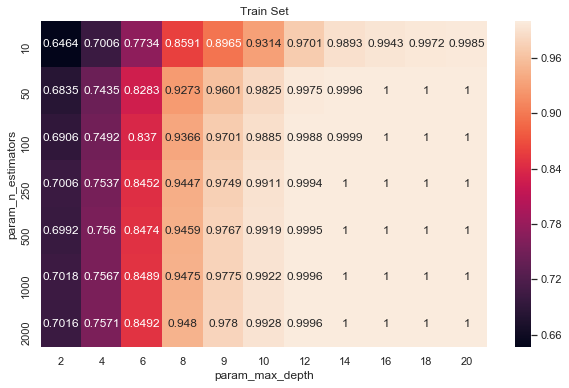

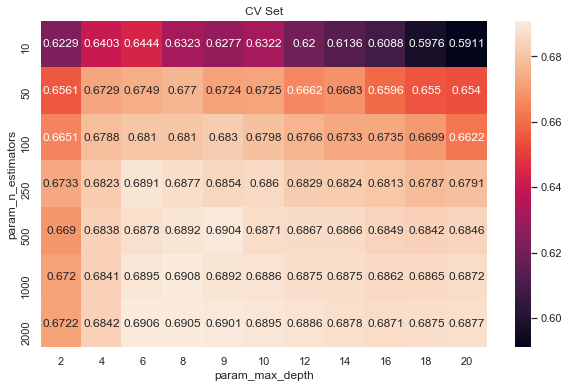

In [81]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [82]:
best_max_depth_tw2v = clf.best_params_['max_depth']
best_n_estimators_tw2v = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_tw2v,best_n_estimators_tw2v))

best value for max depth is 8 and best value for n_estimators is 1000


In [83]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [84]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

## Applying Random Forest with obtained best Hyper parameter on BOW

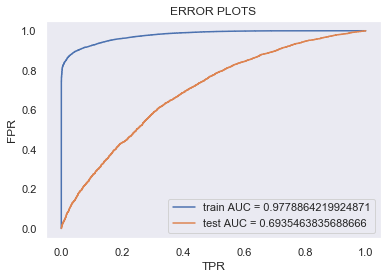

In [85]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
# https://stackoverflow.com/a/57789235
#https://stackoverflow.com/a/56747024

rf = RandomForestClassifier(max_depth= best_max_depth_bow, n_estimators=best_n_estimators_bow, class_weight =  "balanced")
rf.fit(X_train_bow_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(rf, X_train_bow_matrix)    
y_test_pred = batch_predict(rf, X_test_bow_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for BOW

the maximum value of tpr*(1-fpr) 0.854626092973715 for threshold 0.513


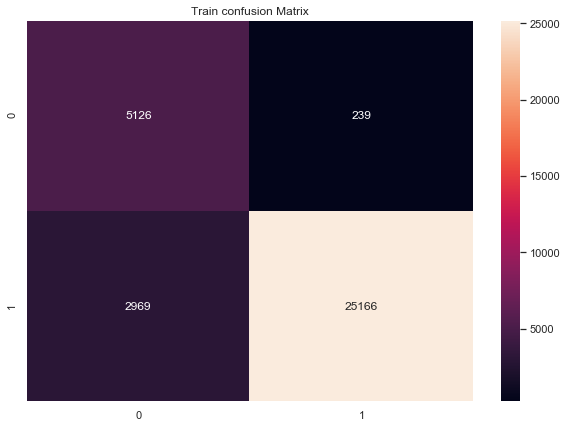

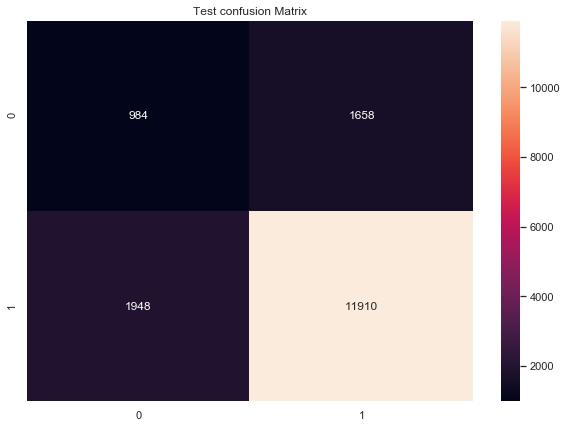

In [86]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247dt

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Applying Random Forest with obtained best Hyper parameter on TFIDF

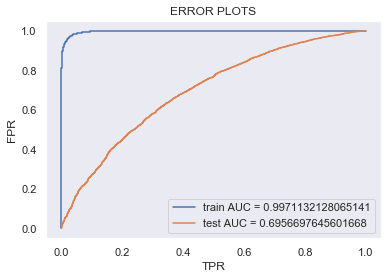

In [90]:
rf = RandomForestClassifier(max_depth= best_max_depth_tfidf, n_estimators=best_n_estimators_tfidf, class_weight =  "balanced")
rf.fit(X_train_tfidf_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(rf, X_train_tfidf_matrix)    
y_test_pred = batch_predict(rf, X_test_tfidf_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for TFIDF

the maximum value of tpr*(1-fpr) 0.943880753344239 for threshold 0.53


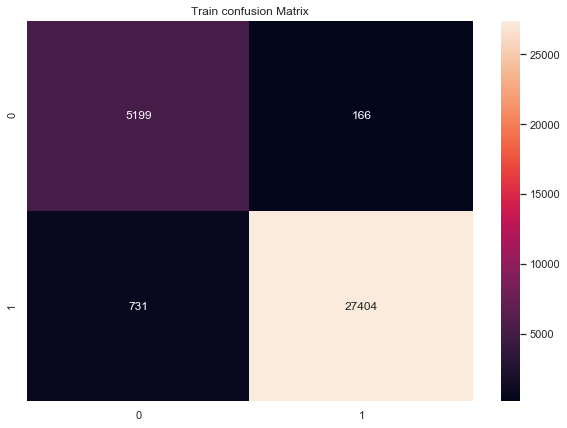

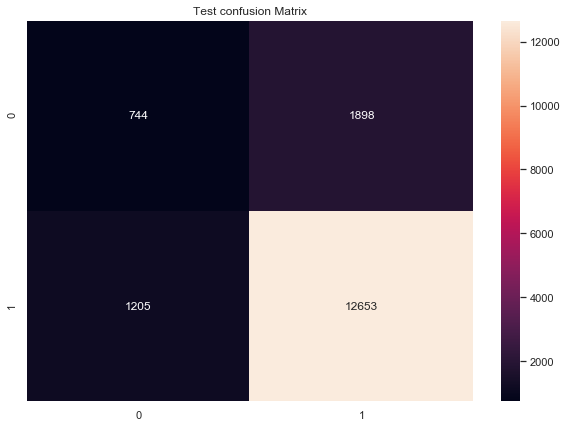

In [91]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Applying Random Forest with obtained best Hyper parameter on AVG W2V representation

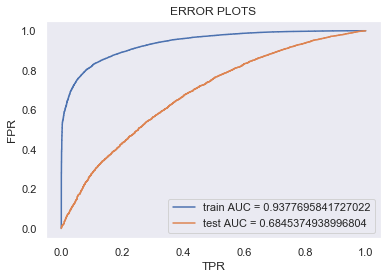

In [92]:
rf = RandomForestClassifier(max_depth= best_max_depth_aw2v, n_estimators=best_n_estimators_aw2v, class_weight =  "balanced")
rf.fit(X_train_aw2v_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(rf, X_train_aw2v_matrix)    
y_test_pred = batch_predict(rf, X_test_aw2v_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for AVG W2V

the maximum value of tpr*(1-fpr) 0.7427289772997353 for threshold 0.524


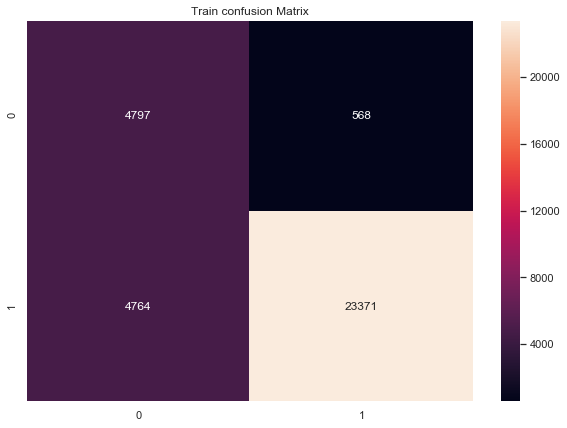

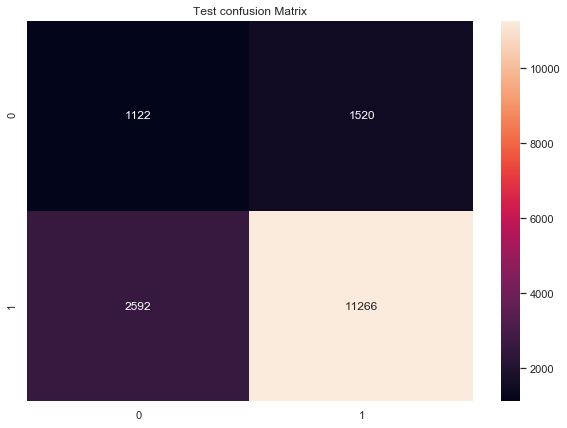

In [93]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Applying Random Forest with obtained best Hyper parameter on TFIDF W2V representation

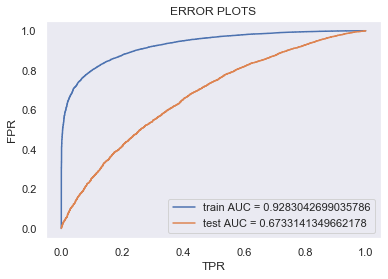

In [94]:
rf = RandomForestClassifier(max_depth= best_max_depth_tw2v, n_estimators= best_n_estimators_tw2v, class_weight =  "balanced")
rf.fit(X_train_tw2v_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(rf, X_train_tw2v_matrix)    
y_test_pred = batch_predict(rf, X_test_tw2v_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for TFIDF W2V

the maximum value of tpr*(1-fpr) 0.7214877477135189 for threshold 0.515


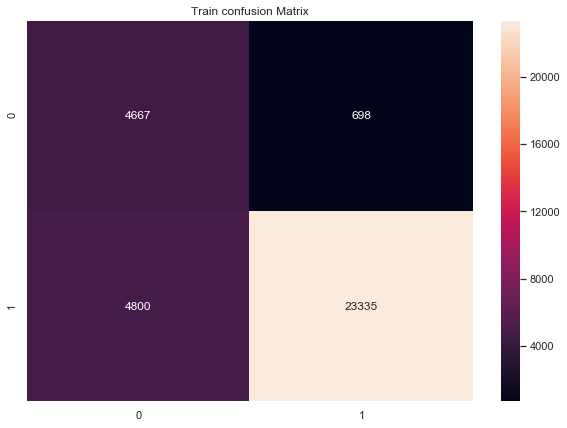

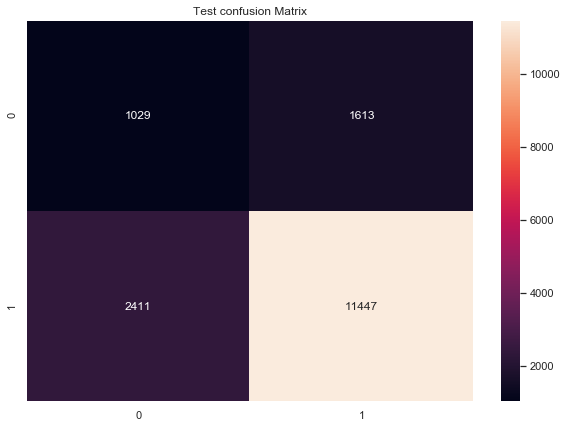

In [95]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

In [96]:
import xgboost as xgb

## Finding Best Hyper parameter using K-Fold CV on BOW representation of text features (Sklearn)

In [98]:
from sklearn.ensemble import GradientBoostingClassifier
parameters = {'max_depth' : [1, 2, 3, 4, 5, 6], 'n_estimators' : [50, 100, 200, 250]}
gbdt = GradientBoostingClassifier()
clf = GridSearchCV(gbdt, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_bow_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [99]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

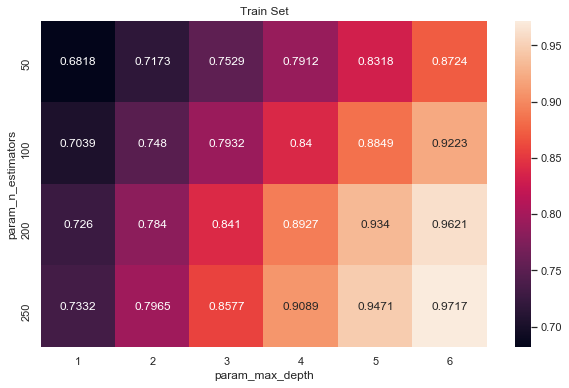

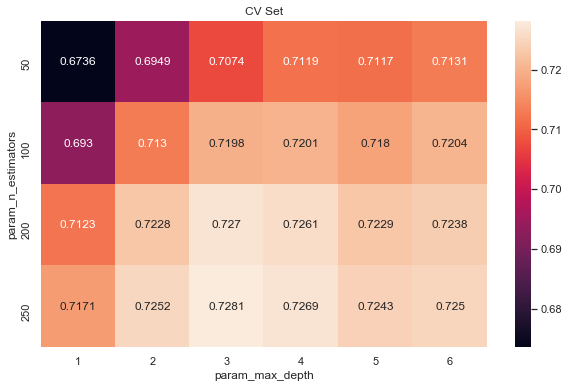

In [100]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [101]:
best_max_depth_bow_gbdt = clf.best_params_['max_depth']
best_n_estimators_bow_gbdt = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_bow_gbdt,best_n_estimators_bow_gbdt))

best value for max depth is 3 and best value for n_estimators is 250


## Finding Best Hyper parameter using K-Fold CV on BOW representation of text features (XGBoost)

In [103]:
parameters = {'max_depth' : [1, 2, 3, 4, 5, 6], 'n_estimators' : [50, 100, 200, 250]}
xgbdt = xgb.XGBClassifier()
clf = GridSearchCV(xgbdt, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_bow_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [104]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

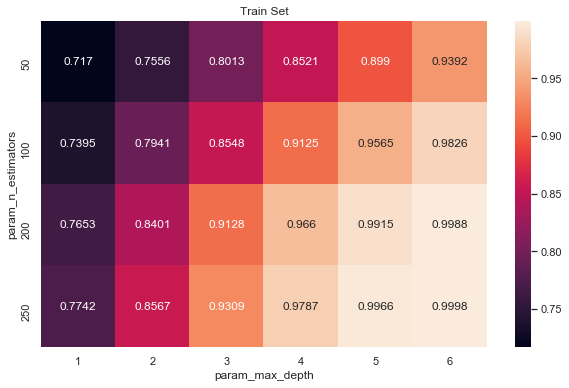

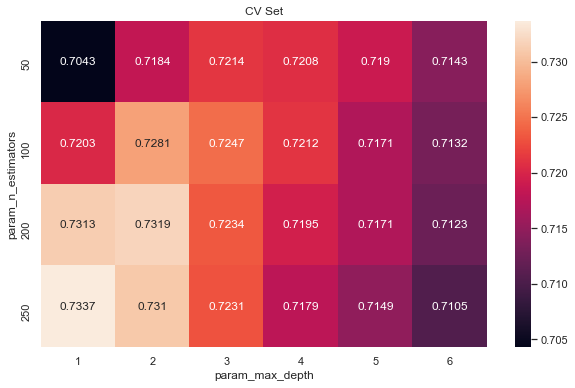

In [105]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [106]:
best_max_depth_bow_xgbdt = clf.best_params_['max_depth']
best_n_estimators_bow_xgbdt = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_bow_xgbdt,best_n_estimators_bow_xgbdt))

best value for max depth is 1 and best value for n_estimators is 250


## Applying GBDT (SKlearn) with obtained best Hyper parameter on BOW

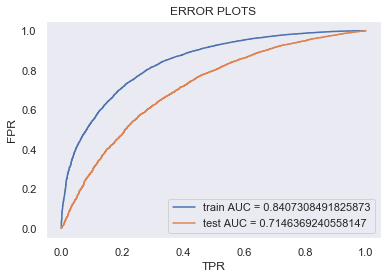

In [107]:
gbdt = GradientBoostingClassifier(max_depth= best_max_depth_bow_gbdt, n_estimators=best_n_estimators_bow_gbdt)
gbdt.fit(X_train_bow_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(gbdt, X_train_bow_matrix)    
y_test_pred = batch_predict(gbdt, X_test_bow_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for BOW

the maximum value of tpr*(1-fpr) 0.5777482186720895 for threshold 0.821


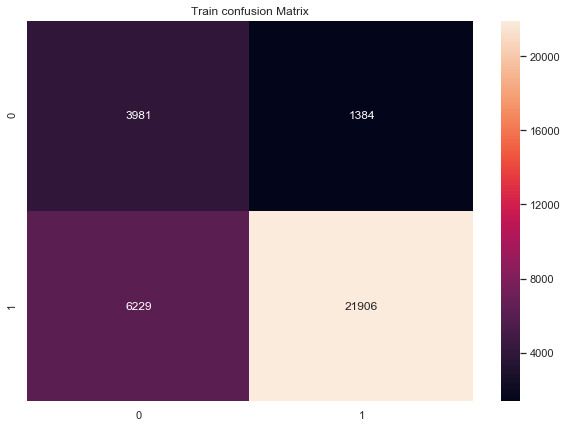

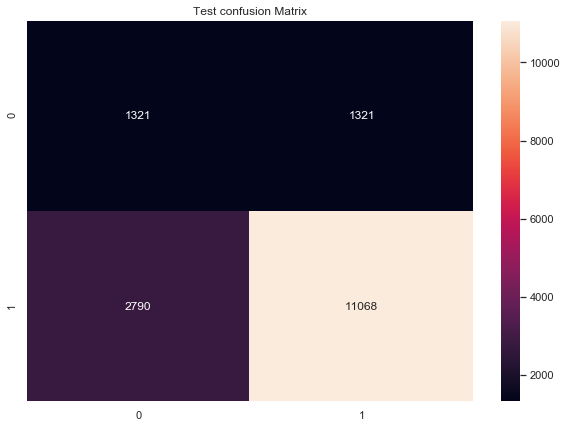

In [108]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247dt

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Applying GBDT (XGBoost) with obtained best Hyper parameter on BOW

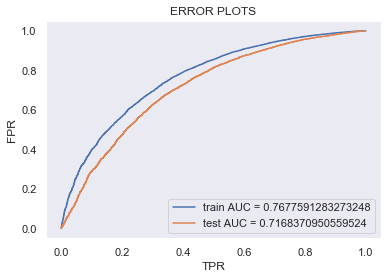

In [109]:
xgbdt = xgb.XGBClassifier(max_depth= best_max_depth_bow_xgbdt, n_estimators=best_n_estimators_bow_xgbdt)
xgbdt.fit(X_train_bow_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(xgbdt, X_train_bow_matrix)    
y_test_pred = batch_predict(xgbdt, X_test_bow_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for BOW

the maximum value of tpr*(1-fpr) 0.4891769760727924 for threshold 0.82


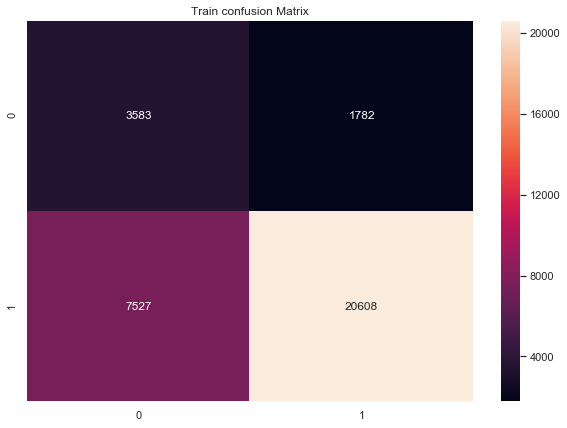

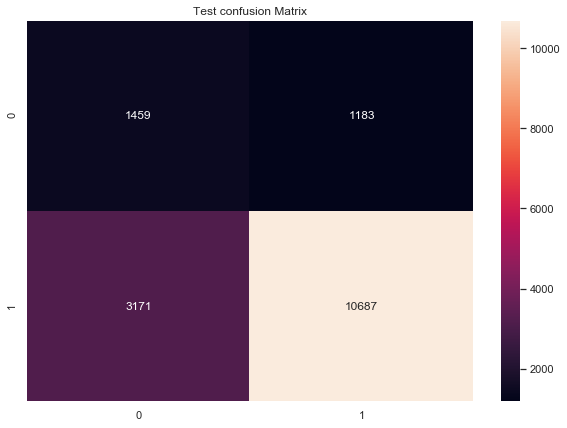

In [110]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247dt

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Finding Best Hyper parameter using K-Fold CV on TFIDF representation of text features

In [112]:
parameters = {'max_depth' : [1, 2, 3, 4, 5, 6], 'n_estimators' : [50, 100, 200, 250]}
xgbdt = xgb.XGBClassifier()
clf = GridSearchCV(xgbdt, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_tfidf_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [113]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

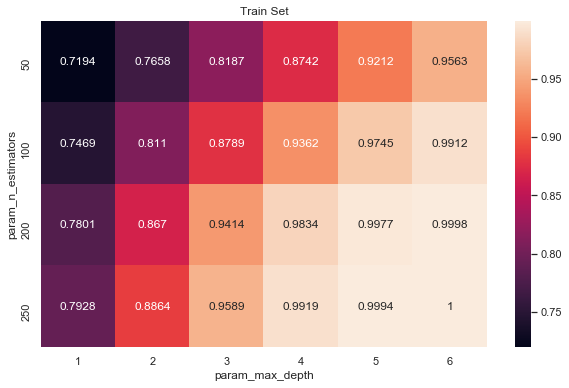

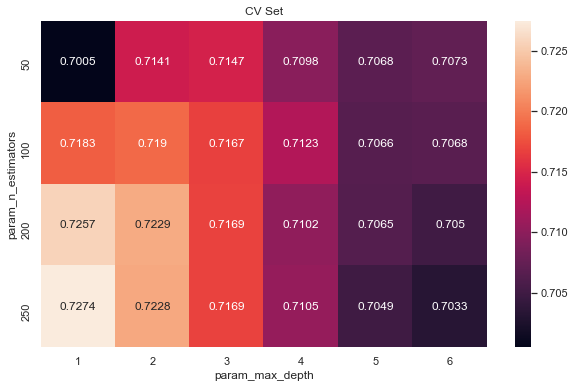

In [114]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [115]:
best_max_depth_tfidf_xgbdt = clf.best_params_['max_depth']
best_n_estimators_tfidf_xgbdt = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_tfidf_xgbdt,best_n_estimators_tfidf_xgbdt))

best value for max depth is 1 and best value for n_estimators is 250


## Applying GBDT with obtained best Hyper parameter on TFIDF

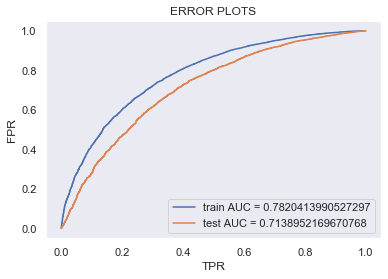

In [144]:
xgbdt = xgb.XGBClassifier(max_depth= best_max_depth_tfidf_xgbdt, n_estimators=best_n_estimators_tfidf_xgbdt)
xgbdt.fit(X_train_tfidf_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(xgbdt, X_train_tfidf_matrix)    
y_test_pred = batch_predict(xgbdt, X_test_tfidf_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Applying GBDT with obtained best Hyper parameter on TFIDF

the maximum value of tpr*(1-fpr) 0.5061325976092833 for threshold 0.821


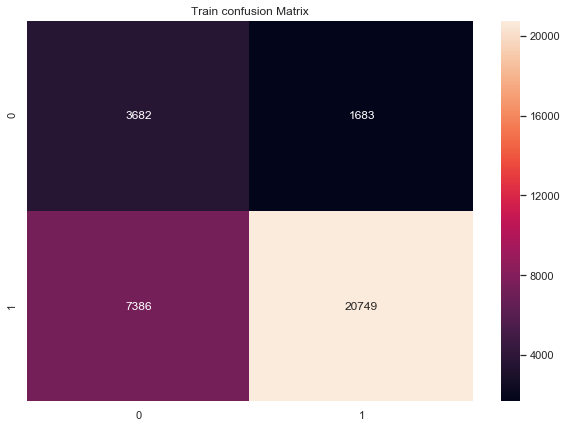

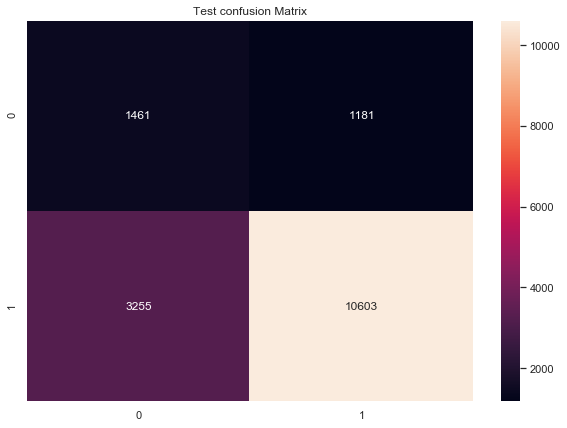

In [145]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247dt

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Finding Best Hyper parameter using K-Fold CV on AVG W2V representation of text features

In [119]:
parameters = {'max_depth' : [1, 2, 3, 4, 5, 6], 'n_estimators' : [50, 100, 200, 250]}
xgbdt = xgb.XGBClassifier()
clf = GridSearchCV(xgbdt, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_aw2v_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [120]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

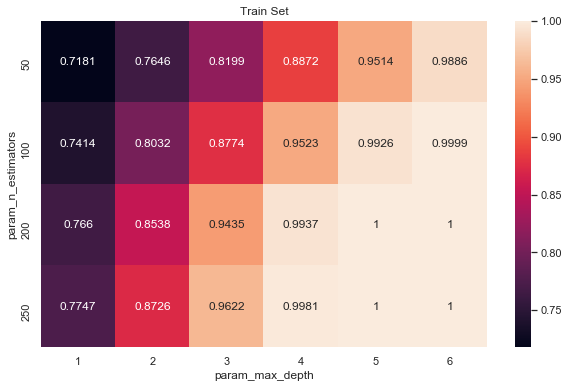

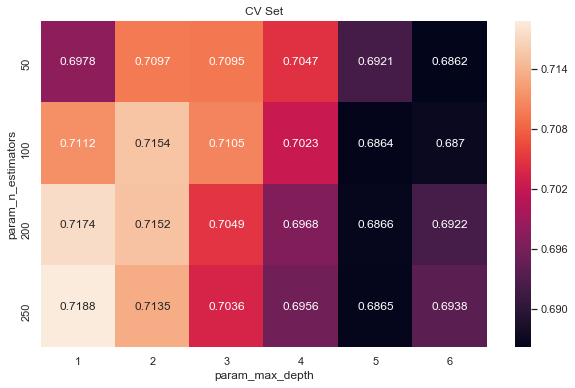

In [121]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [122]:
best_max_depth_aw2v_xgbdt = clf.best_params_['max_depth']
best_n_estimators_aw2v_xgbdt = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_aw2v_xgbdt,best_n_estimators_aw2v_xgbdt))

best value for max depth is 1 and best value for n_estimators is 250


## Applying GBDT with obtained best Hyper parameter on AVG W2V representatio

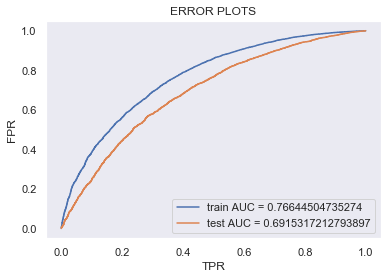

In [123]:
xgbdt = xgb.XGBClassifier(max_depth= best_max_depth_aw2v_xgbdt, n_estimators=best_n_estimators_aw2v_xgbdt)
xgbdt.fit(X_train_aw2v_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(xgbdt, X_train_aw2v_matrix)    
y_test_pred = batch_predict(xgbdt, X_test_aw2v_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for AVG W2V

the maximum value of tpr*(1-fpr) 0.485667025132288 for threshold 0.819


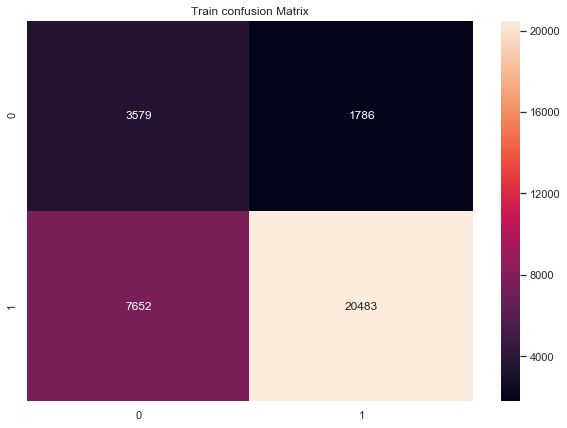

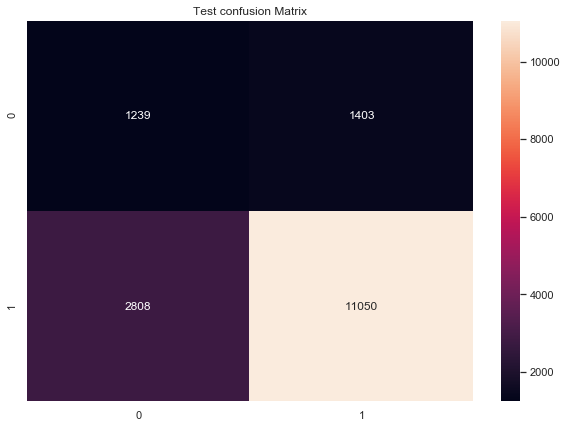

In [124]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247dt

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Finding Best Hyper parameter using K-Fold CV on TFIDF W2V representation of text features

In [132]:
parameters = {'max_depth' : [1, 2, 3, 4, 5, 6], 'n_estimators' : [50, 100, 200, 250]}
xgbdt = xgb.XGBClassifier()
clf = GridSearchCV(xgbdt, parameters, cv=5, scoring='roc_auc', return_train_score=True)
clf.fit(X_train_tw2v_matrix, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_max_depth'])

train_auc= results['mean_train_score']
train_auc_std= results['std_train_score']
cv_auc = results['mean_test_score'] 
cv_auc_std= results['std_test_score']
K =  results['param_max_depth']
M = results['param_n_estimators']

In [133]:
trace1 = go.Scatter3d(x = K, y = M, z = train_auc, name = 'Train')
trace2 = go.Scatter3d(x = K, y = M, z = cv_auc, name = 'Cross Validation')
data = [trace1, trace2]

layout = go.Layout(scene = dict(xaxis = dict(title = 'max_depth'), yaxis = dict(title = 'n_estimators'), 
                               zaxis = dict(title = 'AUC'),))

fig = go.Figure(data = data, layout = layout)
offline.iplot(fig, filename='3d-scatter-colorscale')

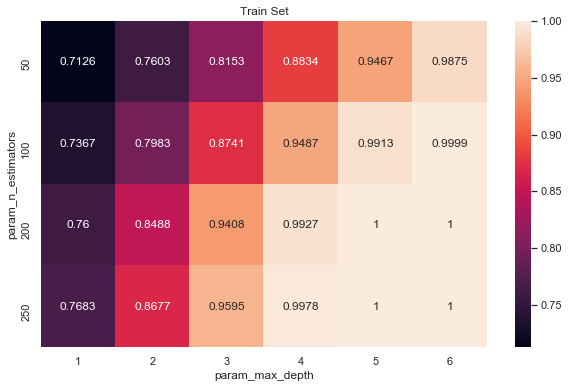

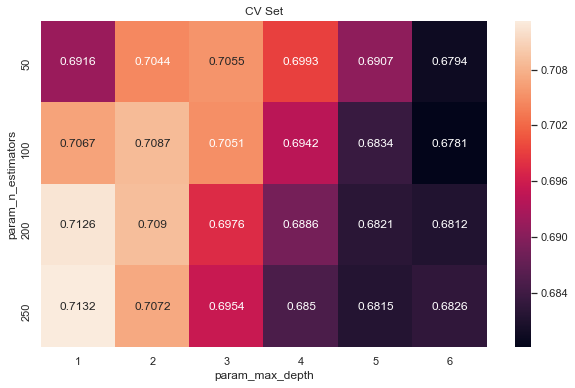

In [134]:
import seaborn as sns; sns.set()
max_scores1 = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(10,6))
plt.title('Train Set')
sns.heatmap(max_scores1.mean_train_score, annot = True, fmt='.4g')
plt.show()


plt.figure(figsize=(10,6))
plt.title('CV Set')
sns.heatmap(max_scores1.mean_test_score, annot = True, fmt='.4g')
plt.show()


In [135]:
best_max_depth_tw2v_xgbdt = clf.best_params_['max_depth']
best_n_estimators_tw2v_xgbdt = clf.best_params_['n_estimators']
print('best value for max depth is {} and best value for n_estimators is {}'.format(best_max_depth_tw2v_xgbdt,best_n_estimators_tw2v_xgbdt))

best value for max depth is 1 and best value for n_estimators is 250


## Applying GBDT with obtained best Hyper parameter on TFIDF W2V representation

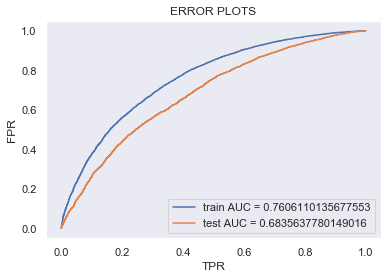

In [136]:
xgbdt = xgb.XGBClassifier(max_depth= best_max_depth_tw2v_xgbdt, n_estimators=best_n_estimators_tw2v_xgbdt)
xgbdt.fit(X_train_tw2v_matrix, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(xgbdt, X_train_tw2v_matrix)    
y_test_pred = batch_predict(xgbdt, X_test_tw2v_matrix)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC = "+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC = "+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("TPR")
plt.ylabel("FPR")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

## Confusion Matrix with predicted and original labels for TFIDF W2V

the maximum value of tpr*(1-fpr) 0.47899968382371577 for threshold 0.824


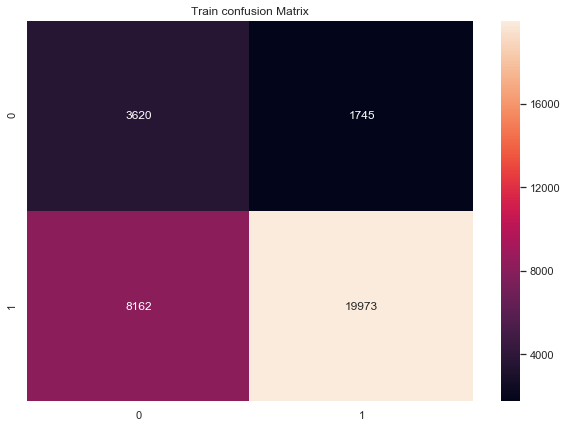

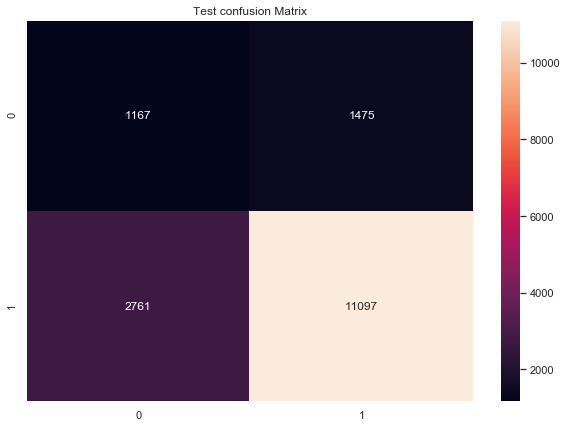

In [137]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
train = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
test = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

#https://stackoverflow.com/a/35572247dt

df_cm = pd.DataFrame(train, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Train confusion Matrix')
sns.heatmap(train, annot=True, fmt="d")
plt.show()

df_cm = pd.DataFrame(test, index = [i for i in range(2)], columns = [i for i in range(2)])
plt.figure(figsize = (10,7))
plt.title('Test confusion Matrix')
sns.heatmap(test, annot=True, fmt="d")
plt.show()

## Conclusion

In [146]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Vectorizer", "Model", "Hyper Parameters", "AUC"]

table.add_row(['BOW', 'Random Forest', ('Max Depth = '+str(best_max_depth_bow) + ', n_estimators = '+str(best_n_estimators_bow)), 0.6935])
table.add_row(['TFIDF', 'Random Forest', ('Max Depth = '+str(best_max_depth_tfidf) + ', n_estimators = '+str(best_n_estimators_tfidf)), 0.6956])
table.add_row(['AVG W2V', 'Random Forests', ('Max Depth = '+str(best_max_depth_aw2v) + ', n_estimators = '+str(best_n_estimators_aw2v)), 0.6845])
table.add_row(['TFIDF W2V', 'Random Forest', ('Max Depth = '+str(best_max_depth_tw2v) + ', n_estimators = '+str(best_n_estimators_tw2v)), 0.6733])
table.add_row(['','','',''])
table.add_row(['BOW', 'GBDT (sklearn)', ('Max Depth = '+str(best_max_depth_bow_gbdt) + ', n_estimators = '+str(best_n_estimators_bow_gbdt)), 0.7146])
table.add_row(['BOW', 'GBDT (XGBoost)', ('Max Depth = '+str(best_max_depth_bow_xgbdt) + ', n_estimators = '+str(best_n_estimators_bow_xgbdt)), 0.7168])
table.add_row(['TFIDF', 'GBDT (XGBoost)', ('Max Depth = '+str(best_max_depth_tfidf_xgbdt) + ', n_estimators = '+str(best_n_estimators_tfidf_xgbdt)), 0.7138])
table.add_row(['AVG W2V', 'GBDT (XGBoost)', ('Max Depth = '+str(best_max_depth_aw2v_xgbdt) + ', n_estimators = '+str(best_n_estimators_aw2v_xgbdt)), 0.6915])
table.add_row(['TFIDF W2V', 'GBDT (XGBoost)', ('Max Depth = '+str(best_max_depth_tw2v_xgbdt) + ', n_estimators = '+str(best_n_estimators_tw2v_xgbdt)), 0.6835])
print(table)


+------------+----------------+-------------------------------------+--------+
| Vectorizer |     Model      |           Hyper Parameters          |  AUC   |
+------------+----------------+-------------------------------------+--------+
|    BOW     | Random Forest  | Max Depth = 18, n_estimators = 2000 | 0.6935 |
|   TFIDF    | Random Forest  | Max Depth = 20, n_estimators = 2000 | 0.6956 |
|  AVG W2V   | Random Forests |  Max Depth = 8, n_estimators = 2000 | 0.6845 |
| TFIDF W2V  | Random Forest  |  Max Depth = 8, n_estimators = 1000 | 0.6733 |
|            |                |                                     |        |
|    BOW     | GBDT (sklearn) |  Max Depth = 3, n_estimators = 250  | 0.7146 |
|    BOW     | GBDT (XGBoost) |  Max Depth = 1, n_estimators = 250  | 0.7168 |
|   TFIDF    | GBDT (XGBoost) |  Max Depth = 1, n_estimators = 250  | 0.7138 |
|  AVG W2V   | GBDT (XGBoost) |  Max Depth = 1, n_estimators = 250  | 0.6915 |
| TFIDF W2V  | GBDT (XGBoost) |  Max Depth = 1, n_es

# Summary

### Random Forest
* BOW vectorizer gave AUC 0.6935 with Max Depth = 18, n_estimators = 2000
* TFIDF vectorizer gave AUC 0.6956 with Max Depth = 20, n_estimators = 2000
* AVG W2V vectorizer gave AUC 0.6845 with Max Depth = 8, n_estimators = 2000
* TFIDF W2V vectorizer gave AUC 0.6733 with Max Depth = 8, n_estimators = 1000
* Trained the Random Forest models with as many as 2000 estimators to see how it behaved.
* After 250 estimators there wasn't much improvement in the AUC.
* Used the obtained best estimators (2000 for 3 sets), which gave train AUC almost = 1 and a reasonably good test AUC

### GBDT 
* BOW vectorizer gave AUC 0.7146 with Max Depth = 3, n_estimators = 250 (sklearn)
* BOW vectorizer gave AUC 0.7168 with Max Depth = 1, n_estimators = 250
* TFIDF vectorizer gave AUC 0.7138 with Max Depth = 1, n_estimators = 250
* AVG W2V vectorizer gave AUC 0.6915 with Max Depth = 1, n_estimators = 250
* TFIDF W2V vectorizer gave AUC 0.6835 with Max Depth = 1, n_estimators = 250

* BOW vectorizer with XGBoost's implementation of GBDT and hyper parameters : Max Depth = 1, n_estimators = 250 has the best AUC.
* XGBoost's implementation of GBDT gave better AUC when compare to sklearn's, hence used it for all remaining sets.
* All the base learners are decision stumps in XGBoost's implementation of GBDT.
* GBDT's AUC were better when compared with Random Forests'